In [1]:
import os, gc

import pandas as pd
import numpy as np
import polars as pl

import xgboost as xgb
xgb.set_config(verbosity=2)
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt

In [2]:
class config:
    data_path = "../data/"
    validation_path = "../data/local_validation/"
    model_path = "../models/"

In [3]:
candidate_df = pd.read_parquet(config.validation_path + "candidate_df_with_user_item_features_and_target.parquet")
display(candidate_df.head())

,session,aid,n_clicks,n_carts,n_orders,item_n_clicks_24h,item_n_carts_24h,item_n_orders_24h,item_n_clicks_7d,item_n_carts_7d,...,user_n_orders_7d,user_n_unique_items_7d,user_n_unique_items_24h,user_session_length,user_avg_click_hour,user_avg_cart_hour,user_avg_order_hour,user_avg_duration_between_events,user_avg_duration_between_clicks,click
0,11098528,42241,2341.0,601.0,253.0,14.0,6.0,0.0,62.0,20.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
1,11098528,1732105,8049.0,1877.0,526.0,34.0,1.0,0.0,255.0,73.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
2,11098528,166160,1902.0,119.0,42.0,10.0,0.0,0.0,90.0,6.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
3,11098528,884502,28184.0,2408.0,930.0,75.0,5.0,1.0,996.0,105.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
4,11098528,1182614,32360.0,3303.0,1426.0,219.0,26.0,2.0,1727.0,187.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0


In [4]:
positives = candidate_df.loc[candidate_df['click']==1]
negatives = candidate_df.loc[candidate_df['click']==0].sample(frac=0.5, random_state=42)
candidate_df = pd.concat([positives,negatives],axis=0,ignore_index=True)

(1110379, 38)

In [8]:
del positives, negatives

In [9]:
FEATURES = candidate_df.columns.drop(["session", "aid", "click"]).tolist()

['n_clicks', 'n_carts', 'n_orders', 'item_n_clicks_24h', 'item_n_carts_24h', 'item_n_orders_24h', 'item_n_clicks_7d', 'item_n_carts_7d', 'item_n_orders_7d', 'item_avg_time_between_clicks', 'item_avg_time_between_carts', 'item_avg_time_between_orders', 'item_avg_click_hour', 'item_avg_cart_hour', 'item_avg_order_hour', 'item_avg_click_day_of_month', 'item_avg_cart_day_of_month', 'item_avg_order_day_of_month', 'user_n_clicks', 'user_n_carts', 'user_n_orders', 'user_n_clicks_24h', 'user_n_carts_24h', 'user_n_orders_24h', 'user_n_clicks_7d', 'user_n_carts_7d', 'user_n_orders_7d', 'user_n_unique_items_7d', 'user_n_unique_items_24h', 'user_session_length', 'user_avg_click_hour', 'user_avg_cart_hour', 'user_avg_order_hour', 'user_avg_duration_between_events', 'user_avg_duration_between_clicks']


In [14]:
candidate_df = candidate_df.sort_values('session').reset_index(drop=True)

,session,aid,n_clicks,n_carts,n_orders,item_n_clicks_24h,item_n_carts_24h,item_n_orders_24h,item_n_clicks_7d,item_n_carts_7d,...,user_n_orders_7d,user_n_unique_items_7d,user_n_unique_items_24h,user_session_length,user_avg_click_hour,user_avg_cart_hour,user_avg_order_hour,user_avg_duration_between_events,user_avg_duration_between_clicks,click
0,11098528,1157882,25238.0,2324.0,779.0,100.0,12.0,1.0,703.0,78.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
1,11098528,428780,1931.0,87.0,30.0,10.0,0.0,0.0,59.0,5.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
2,11098528,600258,3066.0,138.0,0.0,14.0,0.0,0.0,90.0,8.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
3,11098528,1182614,32360.0,3303.0,1426.0,219.0,26.0,2.0,1727.0,187.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0
4,11098528,166160,1902.0,119.0,42.0,10.0,0.0,0.0,90.0,6.0,...,0,1,1,1,22.0,-1.0,-1.0,-1,-1,0.0


In [18]:
skf = GroupKFold(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(
    skf.split(candidate_df, candidate_df["click"], groups=candidate_df["session"])
):
    train_df = candidate_df.loc[train_idx]
    train_df = train_df.sort_values('session', ascending=True)
    qid_train = list(train_df['session'].values)
    train_groups = train_df.groupby('session').aid.agg('count')

    # print(len([x for x in train_df.session if x in valid_df.session]))

    valid_df = candidate_df.loc[valid_idx]
    valid_df = valid_df.sort_values('session', ascending=True)
    qid_valid = list(valid_df['session'].values)
    valid_groups = valid_df.groupby('session').aid.agg('count')

    X_train = train_df[FEATURES]
    y_train = train_df["click"]
    X_valid = valid_df[FEATURES]
    y_valid = valid_df["click"]

    # print(train_df.groupby('session')['click'].value_counts())

    print(train_groups.values.mean(), valid_groups.values.mean())

    dtrain = xgb.DMatrix(X_train, y_train, group=train_groups)
    dvalid = xgb.DMatrix(X_valid, y_valid, group=valid_groups)

    xgb_parms = {"objective": "rank:pairwise", "tree_method": "gpu_hist"}
    model = xgb.train(
        xgb_parms,
        dtrain=dtrain,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        num_boost_round=3000,
        verbose_eval=100,
    )
    model.save_model(config.model_path + f"XGB_fold{fold}_click.xgb")
    del dtrain, dvalid, X_train, X_valid, y_train, y_valid, train_df, valid_df
    gc.collect()
    break

13.346641621650889 13.346660150881158
[0]	train-map:0.62363	valid-map:0.62370
[100]	train-map:0.64356	valid-map:0.64182
[200]	train-map:0.64764	valid-map:0.64441
[300]	train-map:0.65047	valid-map:0.64602
[400]	train-map:0.65258	valid-map:0.64682
[499]	train-map:0.65428	valid-map:0.64748


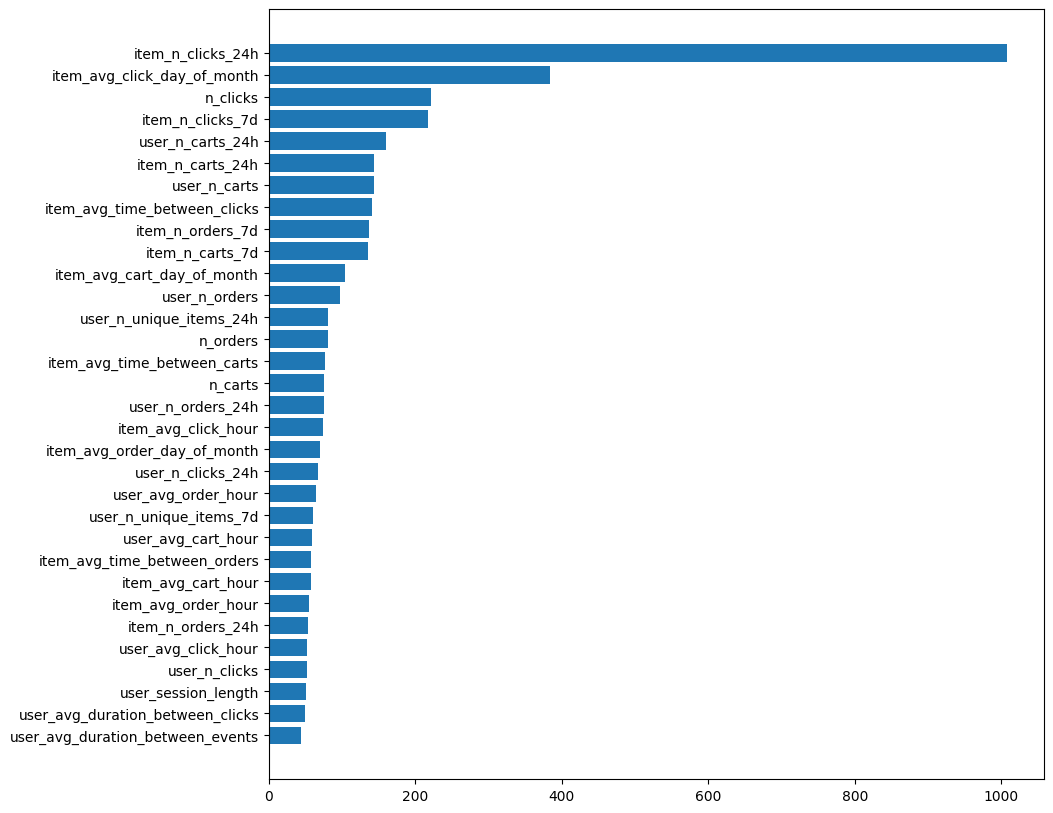

In [24]:
feature_importance_dict = model.get_score(importance_type='gain')
# convert distribution to dataframe
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['feature', 'importance'])
# sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)
# plot
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.show()